Tentando calcular as funções influência dos momentos que vou usar na estimação

1. Ler os dados do projeto dentro de Julia
2. Calcular os momentos usando os dados
3. Calcular IF
    * se a observação não pertence ao conjunto (i.e., o momento é sobre casos pré-corte e a observação fica dentro da corte), IF = 0
    * do contrário, IF = x - Momento(X), onde x é a observação e X é a amostra correspondente àquele momento

Estamos trocando alguns momentos

- 5 e 6 serão taxas de recuperação para S e J em casos "rápidos" reorganizados dentro da corte
    - entrarão no lugar da taxa de recuperação pre-court, pois temos só 2 observações para estes
    
- 9 e 10 serão as variâncias das taxas de recuperação de S e J para reorganizações dentro da corte
    - mais momentos para identificar habilidades iniciais de S e de J
    
- 11 será a variância da duração total de casos ~reorganizados~ dentro da corte
    - ajudará a identificar \rho, torcemos
    - teste no aguia foi com casos reorganizados, mas o MM3 é a média da duração de todos os casos dentro da corte. Portanto, vou calcular a variância de todos os casos dentro da corte no MM11
    
- 12 será o coeficiente da regressão da taxa de recuperação total na duração total para casos reorganizados dentro da corte
    - é o momento 9 de Dou et al, que serve para identificar \rho

In [1]:
#lendo dados do projeto: trilemma_data.xlsx
# using Pkg
# Pkg.add("XLSX")

using XLSX

In [2]:
using DataFrames

In [3]:
using Statistics

In [4]:
ENV["COLUMNS"] = 240 #para aumentar o número de colunas mostradas

240

In [5]:
df = DataFrame(XLSX.readtable("trilemma_data.xlsx", "Sheet1")...)

,processo,fil_date,data_start,final_date,months_fil_start,months_start_plan,months_plan_final,months_fil_final,in_court,D_junior,D_labor,D_senior,R_junior,R_labor,R_senior,assets_total
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0000547-55.2014.8.26.0291,2014-01-22T00:00:00,2014-01-29T00:00:00,2018-07-12T00:00:00,0.233333,19.8333,34.3333333333333,54.4,1.0,3.49201e6,1.38557e6,3.656e6,0.442533,0.941905,0.442533,2.53837e7
2,0000731-65.2011.8.26.0695,2011-03-22T00:00:00,2011-04-08T00:00:00,2017-04-20T00:00:00,0.566667,6.5,66.9666666666667,74.0333,1.0,1.58332e6,9.64064e5,1.61192e5,0.81201,0.941905,0.81201,2.77487e6
3,0003124-79.2014.8.26.0299,2014-05-28T00:00:00,2014-09-25T00:00:00,2018-07-02T00:00:00,4.0,22.0667,23.8,49.8667,1.0,9.85081e6,1.63535e5,3.30049e6,0.36744,0.968244,0.36744,1.1296e7
4,0006202-38.2010.8.26.0100,2010-02-12T00:00:00,2010-03-29T00:00:00,2017-08-25T00:00:00,1.5,9.33333,80.8666666666667,91.7,1.0,3.58351e7,1.72202e6,4.18984e5,0.535184,0.941905,0.535184,1.65361e7
5,0011100-26.2012.8.26.0100,2012-03-06T00:00:00,2012-04-04T00:00:00,2015-11-24T00:00:00,0.966667,25.7,18.6,45.2667,1.0,1.43452e7,0.0,1.41472e7,0.465931,0.0,0.465931,1.86502e7
6,0014297-52.2013.8.26.0100,2013-02-07T00:00:00,2013-02-22T00:00:00,2018-05-15T00:00:00,0.5,17.1333,46.4666666666667,64.1,1.0,3.1438e7,1.41865e6,1.48989e7,0.396523,0.941905,0.536727,6.79508e7
7,0016095-59.2013.8.26.0161,2013-06-17T00:00:00,2014-03-18T00:00:00,2018-11-01T00:00:00,9.13333,27.0333,29.2666666666667,65.4333,1.0,1.00002e7,75754.0,1.02842e5,0.814917,0.941905,0.814917,3.684e6
8,0023189-81.2012.8.26.0100,2012-05-07T00:00:00,2012-06-22T00:00:00,2019-01-15T00:00:00,1.53333,11.6667,68.2666666666667,81.4667,1.0,4.86213e6,0.0,3.844e6,0.206332,0.0,0.206332,2.43727e6
9,0025113-93.2013.8.26.0100,2013-04-03T00:00:00,2013-08-16T00:00:00,2018-09-24T00:00:00,4.5,13.2333,48.9333333333333,66.6667,1.0,1.07158e6,0.0,150000.0,0.448017,0.0,0.448017,299845.0


In [16]:
names(df)

33-element Array{String,1}:
 "processo"
 "fil_date"
 "data_start"
 "final_date"
 "months_fil_start"
 "months_start_plan"
 "months_plan_final"
 "months_fil_final"
 "in_court"
 "D_junior"
 "D_labor"
 "D_senior"
 "R_junior"
 ⋮
 "Vh"
 "L"
 "D"
 "Dj_D"
 "L_D"
 "Vh_D"
 "Reorg_incourt"
 "Reorg_precourt"
 "Liq_incourt"
 "Liq_precourt"
 "months_plan"
 "ln_months_plan"

Próximos passos: 

1) Fazer o eixo y representar porcentagem
2) Melhorar a aparência visual do gráfico
3) Fazer gráfico comparando os dados e as simulações lado a lado usando "dodge"

In [6]:
using Gadfly

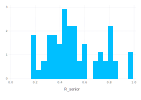

In [15]:
plot(df, x="R_senior",
     Geom.histogram(bincount=20, density=true))

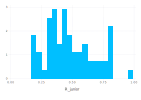

In [14]:
plot(df, x="R_junior",
     Geom.histogram(bincount=20, density=true))

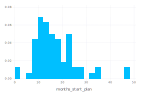

In [13]:
plot(df, x="months_start_plan",
     Geom.histogram(bincount=20, density=true))

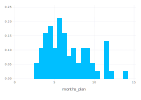

In [17]:
plot(df, x="months_plan",
     Geom.histogram(bincount=20, density=true))

In [18]:
exp(2.011)

7.4707843975693855

In [6]:
names(df)

33-element Array{String,1}:
 "processo"
 "fil_date"
 "data_start"
 "final_date"
 "months_fil_start"
 "months_start_plan"
 "months_plan_final"
 "months_fil_final"
 "in_court"
 "D_junior"
 "D_labor"
 "D_senior"
 "R_junior"
 ⋮
 "Vh"
 "L"
 "D"
 "Dj_D"
 "L_D"
 "Vh_D"
 "Reorg_incourt"
 "Reorg_precourt"
 "Liq_incourt"
 "Liq_precourt"
 "months_plan"
 "ln_months_plan"

In [7]:
INCOURT = filter(df -> df.in_court .== 1.0, df);
PRECOURT = filter(df -> df.in_court .== 0.0, df);

In [8]:
filter(INCOURT -> INCOURT.months_start_plan .== 0, INCOURT)

,processo,fil_date,data_start,final_date,months_fil_start,months_start_plan,months_plan_final,months_fil_final,in_court,D_junior,D_labor,D_senior,R_junior,R_labor,R_senior,assets_total,assets_fixed,plan_date,qtde_agc,outcome_bargain
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any


MM1: average log number of months between observed proposals, for incourt cases

In [9]:
mm1 = mean(INCOURT.ln_months_plan)

1.8192644077060378

In [10]:
if1 = zeros(nrow(df));

for i in 1:length(if1)
    if(df.in_court[i]==0.0)
        if1[i] = zero(0.0)
    else
        if1[i] = df.ln_months_plan[i] - mm1
    end
end

#testando se a média é maior que zero
#qual seria o zero em Julia?
mean(if1)> 0.000000000000001

false

In [11]:
if1

66-element Array{Float64,1}:
  0.474952435617491
  0.05253776919555353
  0.17619147790070522
  0.41432781380105643
 -0.5186835648601771
  0.32861429552702637
  0.3791939760791099
 -0.055675815444679255
  0.07032731075905185
 -0.28959146374080014
  0.627421029261765
  0.3069812001716006
 -0.4219202103995623
  ⋮
 -0.1124981513113752
  0.1242619499939992
 -0.6587211613074377
  0.15943556417226645
 -0.6807194087025572
 -0.30780690363214114
  0.03703358265958823
  0.354223889731351
  0.474952435617491
  0.667723408285787
  0.0
  0.0

In [12]:
findmax(if1)

(0.8292716658637644, 41)

MM2: fraction reorganized given that the case went into court

In [13]:
mm2 = INCOURT
mm2 = size(filter(mm2 -> mm2.outcome_bargain .== "reorganized", mm2),1)/ size(mm2,1)

0.828125

In [14]:
if2 = zeros(nrow(df));

for i in 1:length(if2)
    if(df.in_court[i]==0.0)
        if2[i] = zero(0.0)
    else
        if2[i] = df.Reorg_incourt[i] - mm2
    end
end

mean(if2)

0.0

MM3: avg ln duration of court cases in months

In [15]:
mm3 = mean(log.(INCOURT.months_start_plan))

2.7704847208843

In [16]:
if3 = zeros(nrow(df));

for i in 1:length(if3)
    if(df.in_court[i]==0.0)
        if3[i] = zero(0.0)
    else
        if3[i] = log(df.months_start_plan[i]) - mm3
    end
end

mean(if3)

-3.364312195833808e-17

MM4: Fraction of cases incourt

In [17]:
mm4 = mean(df.in_court)

0.9696969696969697

In [18]:
#função influência do mm4:
if4 = zeros(nrow(df));

# for i in 1:length(if4)
#     println(i)
# end

for i in 1:length(if4)
    if4[i] = df.in_court[i] - mm4
end

In [19]:
mean(if4)

-2.6914497566670462e-17

MM5: avg recovery rate for S given REORGANIZATION in the 25% fastest cases

Includes PRECOURT and INCOURT cases

In [20]:
q = 0.25 #quartil desejado


mm5 = filter(df -> df.outcome_bargain .== "reorganized", df) #casos reorganizados, dentro ou fora da corte

,processo,fil_date,data_start,final_date,months_fil_start,months_start_plan,months_plan_final,months_fil_final,in_court,D_junior,D_labor,D_senior,R_junior,R_labor,R_senior,assets_total
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0000547-55.2014.8.26.0291,2014-01-22T00:00:00,2014-01-29T00:00:00,2018-07-12T00:00:00,0.233333,19.8333,34.3333333333333,54.4,1.0,3.49201e6,1.38557e6,3.656e6,0.442533,0.941905,0.442533,2.53837e7
2,0000731-65.2011.8.26.0695,2011-03-22T00:00:00,2011-04-08T00:00:00,2017-04-20T00:00:00,0.566667,6.5,66.9666666666667,74.0333,1.0,1.58332e6,9.64064e5,1.61192e5,0.81201,0.941905,0.81201,2.77487e6
3,0003124-79.2014.8.26.0299,2014-05-28T00:00:00,2014-09-25T00:00:00,2018-07-02T00:00:00,4.0,22.0667,23.8,49.8667,1.0,9.85081e6,1.63535e5,3.30049e6,0.36744,0.968244,0.36744,1.1296e7
4,0006202-38.2010.8.26.0100,2010-02-12T00:00:00,2010-03-29T00:00:00,2017-08-25T00:00:00,1.5,9.33333,80.8666666666667,91.7,1.0,3.58351e7,1.72202e6,4.18984e5,0.535184,0.941905,0.535184,1.65361e7
5,0011100-26.2012.8.26.0100,2012-03-06T00:00:00,2012-04-04T00:00:00,2015-11-24T00:00:00,0.966667,25.7,18.6,45.2667,1.0,1.43452e7,0.0,1.41472e7,0.465931,0.0,0.465931,1.86502e7
6,0014297-52.2013.8.26.0100,2013-02-07T00:00:00,2013-02-22T00:00:00,2018-05-15T00:00:00,0.5,17.1333,46.4666666666667,64.1,1.0,3.1438e7,1.41865e6,1.48989e7,0.396523,0.941905,0.536727,6.79508e7
7,0016095-59.2013.8.26.0161,2013-06-17T00:00:00,2014-03-18T00:00:00,2018-11-01T00:00:00,9.13333,27.0333,29.2666666666667,65.4333,1.0,1.00002e7,75754.0,1.02842e5,0.814917,0.941905,0.814917,3.684e6
8,0023189-81.2012.8.26.0100,2012-05-07T00:00:00,2012-06-22T00:00:00,2019-01-15T00:00:00,1.53333,11.6667,68.2666666666667,81.4667,1.0,4.86213e6,0.0,3.844e6,0.206332,0.0,0.206332,2.43727e6
9,0025113-93.2013.8.26.0100,2013-04-03T00:00:00,2013-08-16T00:00:00,2018-09-24T00:00:00,4.5,13.2333,48.9333333333333,66.6667,1.0,1.07158e6,0.0,150000.0,0.448017,0.0,0.448017,299845.0


Proximo passo: trocar missing por zero

In [21]:
quartil = quantile(log.(mm5.months_start_plan), q)

2.348195604246098

In [22]:
mm5 = filter(mm5 -> log.(mm5.months_start_plan) .<= quartil, mm5)

,processo,fil_date,data_start,final_date,months_fil_start,months_start_plan,months_plan_final,months_fil_final,in_court,D_junior,D_labor,D_senior,R_junior,R_labor,R_senior,assets_total
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0000731-65.2011.8.26.0695,2011-03-22T00:00:00,2011-04-08T00:00:00,2017-04-20T00:00:00,0.566667,6.5,66.9666666666667,74.0333,1.0,1.58332e6,9.64064e5,1.61192e5,0.81201,0.941905,0.81201,2.77487e6
2,0006202-38.2010.8.26.0100,2010-02-12T00:00:00,2010-03-29T00:00:00,2017-08-25T00:00:00,1.5,9.33333,80.8666666666667,91.7,1.0,3.58351e7,1.72202e6,4.18984e5,0.535184,0.941905,0.535184,1.65361e7
3,0025535-05.2012.8.26.0100,2012-05-18T00:00:00,2012-09-03T00:00:00,2015-10-08T00:00:00,3.6,9.23333,28.4333333333333,41.2667,1.0,8.35837e6,3.05502e5,1.26003e6,0.726299,0.941905,0.726299,2.62484e7
4,0133085-64.2009.8.26.0100,2009-04-01T00:00:00,2009-05-19T00:00:00,2018-12-04T00:00:00,1.6,10.1333,106.066666666667,117.8,1.0,1.66432e7,89600.0,1.12e6,0.377744,0.995025,0.377744,1.25236e7
5,0199374-13.2008.8.26.0100,2008-09-23T00:00:00,2008-10-30T00:00:00,2017-09-20T00:00:00,1.23333,10.4667,97.7666666666667,109.467,1.0,6.89941e6,11642.0,1.16586e6,0.687773,0.941905,0.687773,8.34309e6
6,0228439-53.2008.8.26.0100,2008-06-15T00:00:00,2009-01-09T00:00:00,2016-04-19T00:00:00,6.93333,10.2333,78.3333333333333,95.5,1.0,4.24744e7,9.57444e5,684573.0,0.598274,0.941905,0.598274,1.46139e7
7,1001156-81.2014.8.26.0077,2014-02-25T00:00:00,2014-03-07T00:00:00,2018-10-16T00:00:00,0.333333,10.4667,45.6666666666667,56.4667,1.0,1.73876e6,86650.6,8.51832e5,0.173783,0.941746,0.173783,2.06973e6
8,1006499-72.2016.8.26.0664,2016-08-09T00:00:00,2016-09-12T00:00:00,2019-08-14T00:00:00,1.13333,8.93333,26.6,36.6667,1.0,1.67434e6,60166.6,4.18353e6,0.182776,0.953758,0.180101,1.12756e7
9,1015481-89.2014.8.26.0100,2014-02-18T00:00:00,2014-03-20T00:00:00,2017-05-16T00:00:00,1.0,7.7,30.7333333333333,39.4333,1.0,6.36258e6,3.82754e5,1.26671e7,0.278199,0.941905,0.278199,2.69186e7


In [23]:
mm5 = mean(mm5.R_senior)

0.5652848834410633

In [24]:
quartil

2.348195604246098

In [25]:
if5 = zeros(nrow(df));

for i in 1:length(if5)
    #casos liquidados ou que não estão entre os 25% reorganizados mais rapidamente não influenciam este momento
    if(df.outcome_bargain[i] == "liquidated")
        if5[i] = zero(0.0)
    elseif( (df.outcome_bargain[i] == "reorganized" && log(df.months_start_plan[i]) > quartil ) )
        if5[i] = zero(0.0)
    else
        if5[i] = df.R_senior[i] - mm5
    end
end

mean(if5)

5.046468293750712e-18

In [26]:
#se a IF estiver certa, somente 15 observações não terão valor zero
size(filter(if5 -> if5 .!= 0.0, if5), 1)

#bingo!

15

MM6: avg recovery arte for J given REORGANIZATION in the 25% fastest cases

Includes PRECOURT and INCOURT cases

In [27]:
q = 0.25 #quartil desejado

mm6 = filter(df -> df.outcome_bargain .== "reorganized", df) #casos reorganizados, dentro ou fora da corte

quartil = quantile(log.(mm6.months_start_plan), q)

mm6 = filter(mm6 -> log.(mm6.months_start_plan) .<= quartil, mm6)

mm6 = mean(mm6.R_junior)

0.5562758267330555

In [28]:
if6 = zeros(nrow(df));

for i in 1:length(if6)
    #casos liquidados ou que não estão entre os 25% reorganizados mais rapidamente não influenciam este momento
    if(df.outcome_bargain[i] == "liquidated")
        if6[i] = zero(0.0)
    elseif( (df.outcome_bargain[i] == "reorganized" && log(df.months_start_plan[i]) > quartil ) )
        if6[i] = zero(0.0)
    else
        if6[i] = df.R_junior[i] - mm6
    end
end



mean(if6)

3.027880976250427e-17

In [29]:
#se a IF estiver certa, somente 15 observações não terão valor zero
size(filter(if6 -> if6 .!= 0.0, if6), 1)
#bingo!

15

MM7: junior creditor’s average fraction gain, conditional on an in-court reorganization

In [30]:
INCOURT_REORG = filter(INCOURT -> INCOURT.outcome_bargain .== "reorganized", INCOURT);

In [31]:
INCOURT_REORG.payoff_j = INCOURT_REORG.R_junior .* INCOURT_REORG.D_junior;
INCOURT_REORG.payoff_s = INCOURT_REORG.R_senior .* INCOURT_REORG.D_senior;

In [32]:
mm7 = INCOURT_REORG
mm7 = mean(mm7.payoff_j ./ (mm7.payoff_j .+ mm7.payoff_s ))

0.7835420613728645

In [33]:
df.payoff_j = df.R_junior .* df.D_junior;
df.payoff_s = df.R_senior .* df.D_senior;

In [34]:
if7 = zeros(nrow(df));

for i in 1:length(if7)
    if(df.Reorg_incourt[i]== 0.0) #zero se a observação não for de reorganização dentro da corte
        if7[i] = zero(0.0)
    else
        if7[i] = (df.payoff_j[i] / (df.payoff_j[i] + df.payoff_s[i]) ) - mm7
    end
end

mean(if7)

8.7472117091679e-17

MM8: avg total recovery rate given incourt REORGANIZATION

In [35]:
mm8 = INCOURT_REORG
mm8 = mean((mm8.payoff_s .+ mm8.payoff_j) ./ (mm8.D_senior .+ mm8.D_junior))

0.4987829907385371

In [36]:
if8 = zeros(nrow(df));

for i in 1:length(if8)
    if(df.Reorg_incourt[i]==0.0) #zero se a observação não for de reorganização dentro da corte
        if8[i] = zero(0.0)
    else
        if8[i] = ((df.payoff_s[i] + df.payoff_j[i]) / (df.D_senior[i] + df.D_junior[i] ) )  - mm8
    end
end

mean(if8)

-1.3457248783335231e-17

MM9: variance of recovery rate of S given INCOURT REORG

In [37]:
mm9 = INCOURT_REORG
mm9 = var(mm9.R_senior)

0.04730337223649936

In [38]:
if9 = zeros(nrow(df));

for i in 1:length(if9)
    if(df.Reorg_incourt[i]==0.0) #zero se a observação não for de reorganização dentro da corte
        if9[i] = zero(0.0)
    else
        if9[i] = (df.R_senior[i] - mean(INCOURT_REORG.R_senior))^2  - mm9
    end
end

mean(if9)

-0.0007167177611590845

MM10: variance of recovery rate of J given INCOURT REORG

In [39]:
mm10 = INCOURT_REORG
mm10 = var(mm10.R_junior)

0.0371236002623344

In [40]:
if10 = zeros(nrow(df));

EX = sum(INCOURT_REORG.R_junior)/(size(INCOURT_REORG,1) -1)

0.5048707523435758

In [41]:
var_mm10 = (INCOURT_REORG.R_junior .- mean(INCOURT_REORG.R_junior)).^2

53-element Array{Float64,1}:
 0.002789053419565704
 0.10027660108163412
 0.016359683627714446
 0.0015871227624086638
 0.0008651638684428017
 0.00976585745700842
 0.10212644390826847
 0.08352850891522427
 0.002239950814278151
 0.053339986085220455
 0.02636685363788894
 0.005741219179750359
 0.08206451973259823
 ⋮
 0.24968008893870164
 0.01866665180106977
 0.022480867996735567
 0.06313380207292843
 0.03838949341259603
 0.0002856326530951448
 0.010297729473220208
 0.06404353506350621
 0.00015543254597121992
 0.018671387890644257
 0.021384729179165618
 0.002901937047609261

In [42]:
sum(var_mm10)/ (size(INCOURT_REORG,1) -1)

0.0371236002623344

In [43]:
for i in 1:length(if10)
    if(df.Reorg_incourt[i]==0.0) #zero se a observação não for de reorganização dentro da corte
        if10[i] = zero(0.0)
    else
        if10[i] = (df.R_junior[i] - EX)^2  - mm10
    end
end

#CHECAR SE TODA IF TEM MÉDIA ZERO, OU SE A IF DE VARIÂNCIA TEM UMA PROPRIEDADE DIFERENTE
teste = (if10 .- mean(if10)).^2 .- var(if10)

66-element Array{Float64,1}:
 -0.0005311824080774994
  0.001725712604109414
 -0.0012886695626422935
 -0.0003280469292959191
 -0.00037036376620835075
 -0.0009838730261238823
  0.001936013462050463
  0.0011517362633272708
 -0.000487948956227215
 -0.001449939753589135
 -0.0016033771124212316
 -0.001553450786845816
 -0.0007416974420837271
  ⋮
 -0.0015724905261971529
 -0.00026554952423530264
 -0.0008095695533272478
 -0.0016033771124212316
 -0.0010892843208021763
 -0.0002967731697959505
 -0.001370487612636336
 -0.0016033771124212316
 -0.0014505384179057906
 -0.0005398785060467227
 -0.0016033771124212316
 -0.0016033771124212316

In [44]:
mean(teste)

-2.4297224704989924e-5

In [45]:
for i in 1:length(if10)
    if(df.Reorg_incourt[i]==0.0) #zero se a observação não for de reorganização dentro da corte
        if10[i] = zero(0.0)
    else
        if10[i] = (df.R_junior[i] - mean(INCOURT_REORG.R_junior))^2  - mm10
    end
end

mean(if10)

-0.0005624787918535538

Testando como fica se usar a taxa de recuperação total

In [46]:
INCOURT_REORG.rr = ( (INCOURT_REORG.payoff_s .+ INCOURT_REORG.payoff_j) ./ (INCOURT_REORG.D_senior .+ INCOURT_REORG.D_junior) )

mm100 = INCOURT_REORG
mm100 = var(mm100.rr)

df.rr = ( (df.payoff_s .+ df.payoff_j) ./ (df.D_senior .+ df.D_junior) )

66-element Array{Float64,1}:
 0.4425333996263
 0.812009697811747
 0.367439910190618
 0.535183598438483
 0.465931221036928
 0.4416031370374372
 0.814917171851546
 0.206331898180979
 0.448016770448892
 0.726299399948863
 0.20834879710153104
 0.3846136940315716
 0.419574055786703
 ⋮
 0.30317247680794723
 0.512245559288437
 0.596822618043636
 0.29864371831563
 0.7291006110543988
 0.4828776301319899
 0.3691996989202075
 0.4018748061869991
 0.3503033948177223
 0.44147525898718404
 0.8054827368715078
 0.42502758660975737

In [47]:
if100 = zeros(nrow(df));

for i in 1:length(if100)
    if(df.Reorg_incourt[i]==0.0) #zero se a observação não for de reorganização dentro da corte
        if100[i] = zero(0.0)
    else
        if100[i] = (df.rr[i] - mean(INCOURT_REORG.rr))^2  - mm100
    end
end

mean(if100)

-0.0005769544757636935

MM11: variance ln duration of court cases in months

É a parte de variância, ao invés da média (MM3)

In [48]:
mm11 = var(log.(INCOURT.months_start_plan))

0.18478278604805762

In [49]:
if11 = zeros(nrow(df));

for i in 1:length(if11)
    if(df.in_court[i]==0.0) #zero se a observação não for dentro da corte
        if11[i] = zero(0.0)
    else
        if11[i] = (log(df.months_start_plan[i]) - mean(log.(INCOURT.months_start_plan)) )^2  - mm11
    end
end

mean(if11)

-0.0027997391825463464

MM12: slope of regression of total recovery rate on total duration for incourt reorganizations

Igual ao MM9 de Dou et al

In [50]:
y = INCOURT_REORG

y = log.(y.months_start_plan)

x = INCOURT_REORG
x = log.( (x.payoff_s .+ x.payoff_j) ./ (x.D_senior .+ x.D_junior))

X = [ones(size(x,1)) x]

using LinearAlgebra
mm12 = (X' * X) \ (X' * y)

mm12 = mm12[2]

-0.09622316537215836

In [51]:
if12 = zeros(nrow(df));

length(if12)

66

In [52]:
if12 = zeros(nrow(df));

#precisa recriar y e x aqui embaixo para englobar todas va
Y = log.(df.months_start_plan)
X = log.( (df.payoff_s .+ df.payoff_j) ./ (df.D_senior .+ df.D_junior))

66-element Array{Float64,1}:
 -0.815239338001109
 -0.2082429957738625
 -1.0011954833838048
 -0.6251454163057129
 -0.763717250090964
 -0.817343680245939
 -0.20466880053592001
 -1.5782692504939808
 -0.8029246132300827
 -0.3197929525456788
 -1.568541694581116
 -0.9555158405550106
 -0.8685152351945186
  ⋮
 -1.193453405033666
 -0.66895116093255
 -0.5161353319440475
 -1.208503993624127
 -0.31594354407601666
 -0.727992011193047
 -0.9964175918461682
 -0.9116146662622224
 -1.0489556576531676
 -0.8176332990424642
 -0.21631350816334852
 -0.8556012024942443

In [53]:
for i in 1:length(if12)
    if(df.Reorg_incourt[i]== 0.0) #zero se a observação não for de reorganização dentro da corte
        if12[i] = zero(0.0)
        
        #X e Y são as observações para toda a base de dados
        #x e y são as observações somente para os casos reorganizados dentro da corte
    else
        if12[i] = ( (X[i] - mean(x)) / var(x) ) * (  (Y[i] - mean(y)) - mm12 * (X[i] - mean(x)))
    end
end

mean(if12)

1.4466542442085374e-15

## Empilhando as funções influência

In [54]:
IF = hcat(if1, if2, if3, if4, if5, if6, if7, if8, if9, if10, if11, if12)

66×12 Array{Float64,2}:
  0.474952    0.171875   0.216879    0.030303   0.0         0.0        -0.295013   -0.0562496  -0.0409884   -0.0343345   -0.137746   -0.0603196
  0.0525378   0.171875  -0.898683    0.030303   0.246725    0.255734    0.124059    0.313227    0.0368023    0.063153     0.622848   -2.33372
  0.176191    0.171875   0.323583    0.030303   0.0         0.0        -0.0345052  -0.131343   -0.0234146   -0.0207639   -0.0800765  -0.476169
  0.414328    0.171875  -0.536892    0.030303  -0.0301013  -0.0210922   0.204901    0.0364006  -0.0471296   -0.0355365    0.103471   -0.35981
 -0.518684    0.171875   0.476006    0.030303   0.0         0.0        -0.280067   -0.0328518  -0.0441597   -0.0362584    0.0417992   0.0469229
  0.328614    0.171875   0.0705412   0.030303   0.0         0.0        -0.174337   -0.0571799  -0.0470865   -0.0273577   -0.179807   -0.0331591
  0.379194    0.171875   0.526586    0.030303   0.0         0.0         0.206279    0.316134    0.0384972    0.065002

In [55]:
n = nrow(df);

In [56]:
n^2

4356

In [57]:
W = 1/(n^2) * transpose(IF) * IF

12×12 Array{Float64,2}:
  0.00249284   -0.000890554   0.00163655   -2.80618e-19   2.96277e-6   -6.46293e-6    5.72636e-5   -0.000170432  -8.67422e-5   -7.76229e-5   0.000289587  -0.000984307
 -0.000890554   0.00209122   -0.0011156     8.80083e-21  -4.60101e-6   -4.96125e-8    2.23017e-19  -5.04547e-20  -1.86645e-6   -1.46479e-6  -0.000268802   3.75475e-18
  0.00163655   -0.0011156     0.00267248   -1.24608e-20   5.15236e-6   -9.84364e-6   -9.21594e-5   -0.000171781  -3.81568e-5   -6.69327e-5   0.000447965  -0.000315513
 -2.78721e-19   4.68515e-21  -1.24244e-20   0.000445224  -2.67695e-5   -2.88655e-7    4.1252e-20   -3.87848e-21  -3.29072e-7   -2.58255e-7  -1.28546e-6    6.70719e-19
  2.96277e-6   -4.60101e-6    5.15236e-6   -2.67695e-5    0.000201237   0.00018711    6.5443e-5     0.000165638   1.21829e-5    1.34075e-5   1.10399e-5   -0.000965231
 -6.46293e-6   -4.96125e-8   -9.84364e-6   -2.88655e-7    0.00018711    0.000200397   6.39209e-5    0.000171447   6.65542e-6    1.64536e-5   

In [58]:
omega = inv(W)

12×12 Array{Float64,2}:
  785.415     125.545    -384.757      -1.91692     -45.9041     281.352    -75.9317    160.636      758.064       347.235    -34.9839     81.1904
  125.545     658.155     227.062       1.95168      23.0951    -122.172     52.4404    130.704       -9.33296     938.058     36.3806     18.8511
 -384.757     227.062     786.578     -10.7394     -174.403     -313.809    118.212     153.028     -591.652      1792.57    -225.895     -45.8359
   -1.91692     1.95168   -10.7394   2413.34       2812.35     -2454.11     -92.7117    -27.921    -1071.76        872.925     21.1052     31.3626
  -45.9041     23.0951   -174.403    2812.35      47290.9     -41346.9    -1598.32     -408.705   -18306.9       14485.6      301.92      524.272
  281.352    -122.172    -313.809   -2454.11     -41346.9      48715.6      757.659   -2118.02     15766.7      -20119.4      118.667     499.919
  -75.9317     52.4404    118.212     -92.7117    -1598.32       757.659   2238.46     -450.872 

In [59]:
diag(omega)

12-element Array{Float64,1}:
   785.415499077839
   658.1551794330042
   786.5781250701685
  2413.3419251634896
 47290.90977381732
 48715.58248616276
  2238.4628769331134
  3620.1766894473703
 56549.09914864674
 85141.008193824
  1340.6202056197346
   199.02999677930254

Versão da matriz de ponderação sem os momentos com função influência problemática

Isto é, sem ussar momentos baseados em variância

In [60]:
IF = hcat(if1, if2, if3, if4, if5, if6, if7, if8, if12)

n = nrow(df);

n^2

W = 1/(n^2) * transpose(IF) * IF

omega = inv(W)

diag(omega)

9-element Array{Float64,1}:
   761.6315155552018
   639.7536957371651
   720.8570127155547
  2392.3042984213985
 41222.86601541571
 42875.056212938
  1856.149342980255
  3489.6202316508534
   179.92705467224806

In [61]:
#tentando sem usar o momento 1 para ver o que fica; no limite a gente pode calibrar \mu

IF = hcat(if1, if2, if3, if4, if5, if6, if7, if8, if12)

n = nrow(df);

n^2

W = 1/(n^2) * transpose(IF) * IF

omega = inv(W)

diag(omega)

9-element Array{Float64,1}:
   761.6315155552018
   639.7536957371651
   720.8570127155547
  2392.3042984213985
 41222.86601541571
 42875.056212938
  1856.149342980255
  3489.6202316508534
   179.92705467224806

### Clusterizando por ano?

In [62]:
Years = df.processo[:];

for i in 1:length(Years)
    Years[i] = df.processo[i][12:15]
end

In [63]:
Unique_Years = sort(unique(Years))

10-element Array{Any,1}:
 "2008"
 "2009"
 "2010"
 "2011"
 "2012"
 "2013"
 "2014"
 "2015"
 "2016"
 "2017"

In [64]:
#cada linha da IFCluster representa um ano, e cada coluna representa um momento
IFCluster = zeros(length(Unique_Years), size(IF,2));

for (t, year) in enumerate(Unique_Years)
    for i in 1:nrow(df)
        if(Years[i]==year)
            IFCluster[t,:] += IF[i, :]
        end
    end
end



In [65]:
IFCluster

10×9 Array{Float64,2}:
 -0.381716    0.6875    -1.41401    0.121212    0.155478    0.173496     0.470034   0.879653   -1.89746
 -0.0760958   0.515625  -0.44485    0.0909091  -0.187541   -0.178532     0.380356   0.0169242   0.260778
  0.497171    0.34375   -0.712123   0.0606061  -0.0301013  -0.0210922    0.289858   0.343883   -0.449645
  0.581475    0.515625  -0.885892   0.0909091   0.246725    0.255734     0.313181   0.19667    -2.4255
 -0.932849   -0.453125   0.705306   0.272727    0.161015    0.170024    -0.307306   0.141462    1.76109
 -1.34783     1.75       0.421525   0.484848   -0.123803    0.118739     0.433145   0.0413477   0.493622
  1.63945    -0.59375    1.84552    0.424242   -0.248848   -0.22182     -1.58421   -1.01107    -0.630971
 -0.746527    0.6875    -0.967889   0.121212    0.295652    0.075695     0.607707  -0.18185    -0.571497
  0.148193   -2.625      1.09176    0.242424   -0.385184   -0.3735      -0.602764  -0.427018    3.45958
  0.618725   -0.828125   0.360652  -1

In [66]:
W2 = 1/(n^2) * transpose(IFCluster) * IFCluster

9×9 Array{Float64,2}:
  0.00162386   -0.000953857   0.000599512  -0.000325606  -0.000117891  -0.000162492  -0.000762057  -0.000418862  -0.000765094
 -0.000953857   0.00293664   -0.00147171    0.000390005   0.000253214   0.000331894   0.00106022    0.000559593  -0.00266507
  0.000599512  -0.00147171    0.00225646    6.95546e-5   -0.000320492  -0.000251934  -0.00126763   -0.000851565   0.00221576
 -0.000325606   0.000390005   6.95546e-5    0.000973927  -8.71073e-5   -1.08278e-5   -0.000110368  -8.01171e-5    0.000176152
 -0.000117891   0.000253214  -0.000320492  -8.71073e-5    0.000108741   8.229e-5      0.000177516   0.000126663  -0.000470819
 -0.000162492   0.000331894  -0.000251934  -1.08278e-5    8.229e-5      8.38531e-5    0.000162843   0.000135813  -0.000418725
 -0.000762057   0.00106022   -0.00126763   -0.000110368   0.000177516   0.000162843   0.000934828   0.000528981  -0.000790413
 -0.000418862   0.000559593  -0.000851565  -8.01171e-5    0.000126663   0.000135813   0.000528981 

In [67]:
omega2 = inv(W2)

9×9 Array{Float64,2}:
 504739.0        -7.37773e5   5.3924e6    2.23011e6   1.21021e7  -1.62709e7   5.82004e6   4.31208e6  -1.30073e6
     -7.37773e5   1.1092e6   -8.04175e6  -3.32276e6  -1.80194e7   2.42619e7  -8.67806e6  -6.4245e6    1.94857e6
      5.3924e6   -8.04175e6   5.85109e7   2.41776e7   1.31206e8  -1.76607e8   6.31246e7   4.677e7    -1.41587e7
      2.23011e6  -3.32276e6   2.41776e7   9.99254e6   5.42205e7  -7.29764e7   2.60853e7   1.93264e7  -5.84978e6
      1.21021e7  -1.80194e7   1.31206e8   5.42205e7   2.94317e8  -3.96116e8   1.4154e8    1.04895e8  -3.17407e7
     -1.62709e7   2.42619e7  -1.76607e8  -7.29764e7  -3.96116e8   5.3321e8   -1.90512e8  -1.41192e8   4.27353e7
      5.82004e6  -8.67806e6   6.31246e7   2.60853e7   1.4154e8   -1.90512e8   6.811e7     5.04519e7  -1.52749e7
      4.31208e6  -6.4245e6    4.677e7     1.93264e7   1.04895e8  -1.41192e8   5.04519e7   3.7395e7   -1.13157e7
     -1.30073e6   1.94857e6  -1.41587e7  -5.84978e6  -3.17407e7   4.27353e7  -1.52

In [68]:
diag(omega2)

9-element Array{Float64,1}:
 504739.0175441499
      1.109199238229877e6
      5.851090074429358e7
      9.992540752595607e6
      2.9431664757013345e8
      5.332102290312567e8
      6.810996404065523e7
      3.739498068158169e7
      3.4289227279857565e6

In [69]:
using DelimitedFiles

writedlm( "WCluster.csv",  omega2, ',')

In [70]:
WCluster = readdlm("WCluster.csv", ',')

9×9 Array{Float64,2}:
 504739.0        -7.37773e5   5.3924e6    2.23011e6   1.21021e7  -1.62709e7   5.82004e6   4.31208e6  -1.30073e6
     -7.37773e5   1.1092e6   -8.04175e6  -3.32276e6  -1.80194e7   2.42619e7  -8.67806e6  -6.4245e6    1.94857e6
      5.3924e6   -8.04175e6   5.85109e7   2.41776e7   1.31206e8  -1.76607e8   6.31246e7   4.677e7    -1.41587e7
      2.23011e6  -3.32276e6   2.41776e7   9.99254e6   5.42205e7  -7.29764e7   2.60853e7   1.93264e7  -5.84978e6
      1.21021e7  -1.80194e7   1.31206e8   5.42205e7   2.94317e8  -3.96116e8   1.4154e8    1.04895e8  -3.17407e7
     -1.62709e7   2.42619e7  -1.76607e8  -7.29764e7  -3.96116e8   5.3321e8   -1.90512e8  -1.41192e8   4.27353e7
      5.82004e6  -8.67806e6   6.31246e7   2.60853e7   1.4154e8   -1.90512e8   6.811e7     5.04519e7  -1.52749e7
      4.31208e6  -6.4245e6    4.677e7     1.93264e7   1.04895e8  -1.41192e8   5.04519e7   3.7395e7   -1.13157e7
     -1.30073e6   1.94857e6  -1.41587e7  -5.84978e6  -3.17407e7   4.27353e7  -1.52

In [71]:
diag(WCluster)

9-element Array{Float64,1}:
 504739.0175441499
      1.109199238229877e6
      5.851090074429358e7
      9.992540752595607e6
      2.9431664757013345e8
      5.332102290312567e8
      6.810996404065523e7
      3.739498068158169e7
      3.4289227279857565e6